# Text classification of Voice Commands
### Sections:
* [1. Load datasets](#section1)
* [2. Different model for classification](#section2)
    * [2.1 Naive Bayes](#section2.1)
    * [2.2 Logistic Regression](#section2.2)
* [3. Model Evaluation](#section3)
* [4. Save model](#section4)

Some useful imports:

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from pprint import pprint

import pickle

%matplotlib inline

Fix random seed:

In [2]:
np.random.seed(1234)

# 1. Load the data

In [6]:
data = pd.read_csv('500k.csv',sep='\t',header=None, names=['INN', 'KPP','Type','Description'])
data.drop(['INN', 'KPP'], axis=1, inplace=True)
data = pd.DataFrame({'Type': np.array(data['Type'], dtype='int'), 'Description': np.array(data['Description'])})
data = data[['Type', 'Description']]

In [8]:
data = data.iloc[::10].copy()

In [10]:
print('Data size: ', data.shape)
data.head()

Data size:  (50000, 2)


,Type,Description
0,4022,Предоплата за поверку СИ по счетам N 140808 от...
10,4001,Переоценка счета. 210.88 USD по курсу 57.2323№...
20,4040,государственная пошлина запроведение аттестаци...
30,5107,Возмещение денежных средств по операциям с исп...
40,4041,Выдача наличных согласно договора 50365 от 07....


In [11]:
data.dropna(inplace=True)
print('Data size: ', data.shape)

Data size:  (49823, 2)


In [12]:
X = np.array(data['Description'])
y = np.array(data['Type'], dtype = 'int')

# 2. Data analysis

In [13]:
print('The number of classes: ', len(np.unique(y)))
unique, counts = np.unique(y, return_counts=True)
data_dict = dict(zip(unique, counts))

The number of classes:  96


In [14]:
def idx_by_count(count):
    return np.where(np.array(list(data_dict.values())) == count)[0]

def key_by_count(count):
    return np.array(list(data_dict.items()))[:,0][idx_by_count(count)]

Plot now a diagram of interclass distribution:

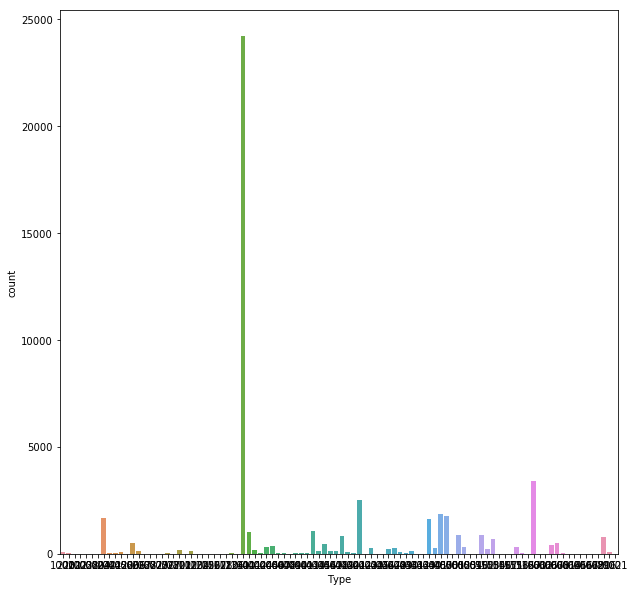

In [15]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data)

We see that we have 25% of our data belonging to one class, which means that our data is strongly unbalanced. Find this class:

In [16]:
print("Most populated class is: ", key_by_count(counts.max()))

Most populated class is:  [3001]


Delete 75% of this class instances:

In [17]:
data_cleared= data.drop(data[data.Type==3001].index[::2], inplace=False)
data_cleared = data_cleared.drop(data_cleared[data_cleared.Type==3001].index[::2], inplace=False)

In [18]:
data_cleared.shape

(31657, 2)

In [19]:
data_3001_1 = data.drop(data[data.Type == 3001].index[1::2], inplace=False)
data_3001_2 = data_3001_1.drop(data_3001_1[data_3001_1.Type == 3001].index[1::2], inplace=False)
data_3001_1 = data_3001_1[data_3001_1.Type == 3001].copy()
data_3001_2 = data_3001_2[data_3001_2.Type == 3001].copy()
data_3001 = pd.concat([data_3001_1, data_3001_2], axis=0, join='inner')

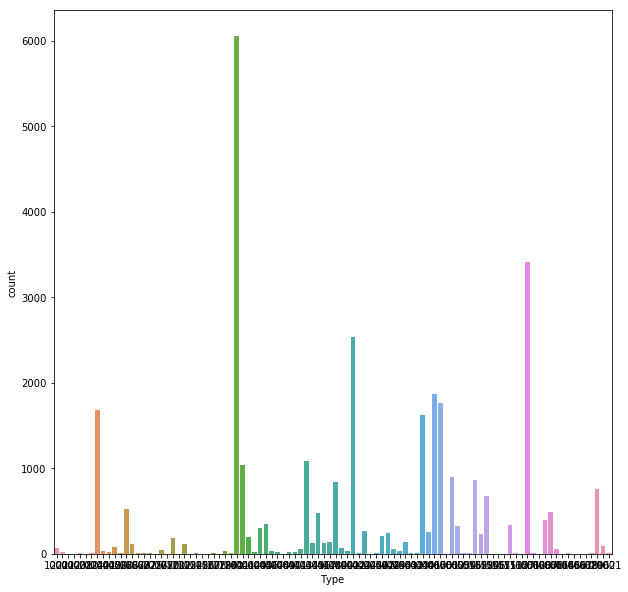

In [20]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data_cleared)

And we have several classes that are very rare:

In [21]:
print("Classes with only 1 sample: ", key_by_count(1))

Classes with only 1 sample:  [2002 2080 2104 2106 2110 4009 4025 5106 6014]


In [23]:
print("Classes with only 2 sample: ", key_by_count(2))

Classes with only 2 sample:  [2010 2076 2107 5107 5111 5127 6006]


Delete the entries in data with the total number of a class less than 10:

In [24]:
def delete_minor_classes(data, min_count = 10):
    data_copy = data.copy()
    for i in range(1, min_count + 1):
        classes = key_by_count(i)
        for class_name in classes:
            data_copy.drop(data_copy[data_copy.Type==class_name].index, inplace=True)
    return data_copy

In [25]:
data_cleared = delete_minor_classes(data_cleared, 10)

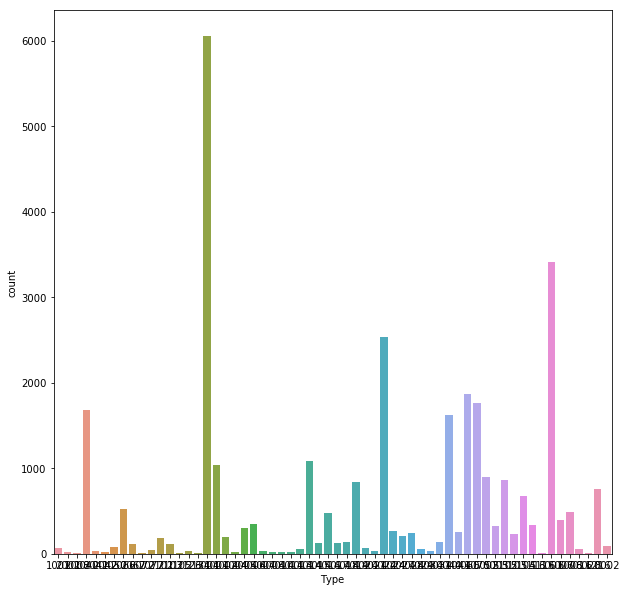

In [26]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data_cleared)

# 3. Preprocessing and training pipeline

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

## 3.1 Straigth-forward classification

Split the data into train and test sets:

In [28]:
test_size = 0.2
X = np.array(data['Description'])
y = np.array(data['Type'], dtype = 'int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [29]:
parameters = {'vect__ngram_range': [(1, 2), (1,3)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-3, 1e-6, 1e-1),
}

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='log', penalty='l2',
                                           alpha=1e-3, random_state=1234,
                                           max_iter=6, tol=None, n_jobs=-1)),
])

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=-1, verbose=True)

Train a classifier:

In [ ]:
gs_clf.fit(X_train, y_train)
best_clf = gs_clf.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\i344436\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Compute the accuracy:

In [ ]:
gs_clf.best_params_

In [ ]:
gs_clf.best_score_

If we use the initial data set, the resulting accuracy is much worse:

In [ ]:
print('Accuracy on the train: ', accuracy_score(y_train, best_clf.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, best_clf.predict(X_test)))

## 3.2 Classification using cleared data

As we have seen, our data is highly unbalanced, thus we can try to use cleared data, where the most populated class is reduced.

Split the data into train and test sets:

In [30]:
data_ = data_cleared.copy()

In [31]:
from sklearn.model_selection import train_test_split
test_size = 0.2
X = np.array(data_['Description'])
y = np.array(data_['Type'], dtype = 'int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [32]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-5, 1e-6, 1e-7,1e-8),
}

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='log', penalty='l2',
                                           alpha=1e-3, random_state=1234,
                                           max_iter=5, tol=None, n_jobs=-1)),
])

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=-1, verbose=True)

Train a classifier:

In [ ]:
gs_clf.fit(X_train, y_train)
best_clf = gs_clf.best_estimator_

Compute the accuracy:

In [ ]:
gs_clf.best_params_

In [ ]:
gs_clf.best_score_

In [ ]:
print('Accuracy on the train: ', accuracy_score(y_train, best_clf.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, best_clf.predict(X_test)))

## 3.3 Classification without duplicates in data

In [33]:
data_cleared.shape

(31519, 2)

In [34]:
data_wh_dup = data_cleared.drop_duplicates(subset=['Description'], inplace=False)
data_wh_dup.shape

(28688, 2)

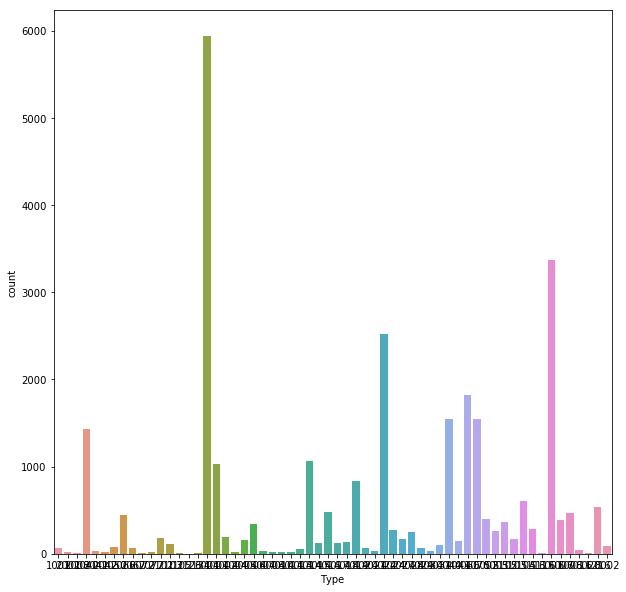

In [35]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data_wh_dup)

In [36]:
test_size = 0.2
X = np.array(data_wh_dup['Description'])
y = np.array(data_wh_dup['Type'], dtype = 'int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [37]:
parameters = {'vect__ngram_range': [(1,3), (1,4)],
              'vect__min_df': (1e-20, 1e-10),
              #'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-3, 1e-6)
}

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer(norm='l1', use_idf=True)),
                     ('clf', SGDClassifier(loss='log', penalty='l1',
                                           random_state=1234,
                                           max_iter=5, tol=None, n_jobs=-1)),
])

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=-1, verbose=5)

Train a classifier:

In [ ]:
gs_clf.fit(X_train, y_train)
best_clf = gs_clf.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


Compute the accuracy:

In [ ]:
gs_clf.best_params_

In [ ]:
gs_clf.best_score_

In [ ]:
print('Accuracy on the train: ', accuracy_score(y_train, best_clf.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, best_clf.predict(X_test)))

### 3.4 TEST

In [38]:
test_size = 0.2
X = np.array(data_wh_dup['Description'])
y = np.array(data_wh_dup['Type'], dtype = 'int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [39]:
parameters = {'vect__ngram_range': [(1,3)],
              'clf__alpha': (1e-1, 1e-7)
}

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer(use_idf=True)),
                     ('clf', SGDClassifier(loss='log', penalty='l1',
                                           random_state=1234,
                                           max_iter=5, tol=None, n_jobs=-1)),
])

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=-1, verbose=2)

Train a classifier:

In [40]:
gs_clf.fit(X_train, y_train)
best_clf = gs_clf.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\i344436\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   32.6s remaining:   32.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   48.0s finished


Compute the accuracy:

In [41]:
gs_clf.best_params_

{'clf__alpha': 1e-07, 'vect__ngram_range': (1, 3)}

In [42]:
gs_clf.best_score_

0.88405228758169929

In [43]:
print('Accuracy on the train: ', accuracy_score(y_train, best_clf.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, best_clf.predict(X_test)))

Accuracy on the train:  0.998518518519
Accuracy on the test:  0.898919484141


# 3. Model Analysis

Some useful function:

In [44]:
def class_by_idx(data, index):
    y = np.array(data['Type'], dtype = 'int')
    unique, counts = np.unique(y, return_counts=True)
    data_dict = dict(zip(unique, counts))
    return np.array(list(data_dict.keys()))[index]

def find_most_probable_class(data, probabilities, n_classes=2):
    probabilities = probabilities[0]
    sorted_prob = np.sort(probabilities)
    idx_sorted_prob = probabilities.argsort()
    return class_by_idx(data, idx_sorted_prob[-n_classes:][::-1]), sorted_prob[-n_classes:][::-1]

In [45]:
y_pred = best_clf.predict(X_test)

mistakes = np.array([i for i in range(len(y_pred)) if (y_pred[i] != y_test[i])])

In [46]:
mistakes[:5]

array([ 2,  3, 22, 33, 36])

### Consider several difficult cases:

### 1. Similar entries - different classes

We see that our classifier confuses **4028** and **3001** classes, and in our data we have several entries, which belong to that classes:

In [47]:
entry = 'Арендная плата за ноябрь 2015г по ДАЗУ 45-ю от 20.02.2007г. НДС не облагается№REF<<ИМЯ>ИНН=6646001507КПП=664601001'
data_cleared[data_cleared.Description == entry]

,Type,Description


In [48]:
probs = best_clf.predict_proba([X_test[3]])

In [49]:
find_most_probable_class(data_cleared, probs, 2)

(array([5003, 5103]), array([ 0.99841318,  0.00138896]))

In [50]:
entry = 'Арендная плата за октябрь 2013г. по ДАЗУ 33 от 13.12.2005 НДС не облагается<<ИМЯ>УФК по Свердловской области (МУГИСО)ИНН=6658091960КПП=667001001'
data_cleared[data_cleared.Description == entry]

,Type,Description


### 2. Abbreviations

In [51]:
X_test[7]

'Зачислить на карту прочие выплаты согласно положения от 01.01.2008г. НДС не облагается№REF8899<<ИМЯ>Сивцов Сергей БорисовичИНН=000000000000КПП='

In [52]:
j = 7
print(str(X_test[j]) + '\ntrue: ' + str(y_test[j]) + '\npred: ' + str(y_pred[j]))

Зачислить на карту прочие выплаты согласно положения от 01.01.2008г. НДС не облагается№REF8899<<ИМЯ>Сивцов Сергей БорисовичИНН=000000000000КПП=
true: 3001
pred: 3001


In [53]:
prob = best_clf.predict_proba([X_test[j]])
find_most_probable_class(data_cleared, prob, j)

(array([3001, 4014, 5002, 4005, 4018, 4008, 1001]),
 array([  9.99705396e-01,   1.12886262e-04,   1.61163865e-05,
          1.25658001e-05,   1.00905179e-05,   9.81668380e-06,
          7.66317311e-06]))

### 3. Similar classes


The first thing to consider is that classes **2101** and **2103** are pretty similar:

And our classifier works fine:

In [54]:
def lazy_print(idx):
    print('%r => %s, true: %s' % (X_test[idx], best_clf.predict([X_test[idx]]),y_test[idx]))

In [55]:
lazy_print(12)

'Комиссия за перевод средств. П/п N 22716№REF<<ИМЯ>ПАО РОСБАНКИНН=7730060164КПП=997950001' => [6001], true: 6001


In [56]:
find_most_probable_class(data_cleared, best_clf.predict_proba([X_test[12]]), n_classes=3)

(array([6001, 5002, 2077]),
 array([  9.99996772e-01,   9.61099452e-07,   3.85046516e-07]))

In [57]:
mistakes.shape

(580,)

### 4. Other mistakes

In [58]:
mistakes

array([   2,    3,   22,   33,   36,   52,   77,  101,  102,  103,  106,
        107,  108,  109,  112,  123,  130,  151,  179,  182,  194,  203,
        214,  222,  225,  239,  246,  252,  258,  269,  301,  304,  319,
        340,  367,  390,  410,  412,  422,  424,  429,  440,  444,  468,
        472,  475,  481,  514,  517,  518,  523,  535,  546,  552,  555,
        556,  557,  571,  576,  580,  603,  607,  614,  617,  635,  641,
        647,  652,  664,  665,  668,  679,  687,  691,  696,  697,  736,
        741,  744,  750,  784,  791,  794,  795,  803,  835,  839,  851,
        862,  863,  891,  904,  909,  935,  957,  977,  981,  982,  986,
        987,  995,  996, 1003, 1005, 1007, 1009, 1026, 1028, 1030, 1051,
       1052, 1056, 1058, 1073, 1101, 1118, 1119, 1128, 1133, 1137, 1151,
       1157, 1192, 1193, 1203, 1220, 1253, 1275, 1292, 1306, 1319, 1324,
       1326, 1351, 1357, 1358, 1370, 1378, 1379, 1383, 1385, 1388, 1417,
       1432, 1433, 1441, 1446, 1479, 1495, 1497, 15

In [59]:
lazy_print(9)

'Перевод собственных средств. НДС не облагается.№REF00185<<ИМЯ>ИНН=4823006703КПП=997550001' => [5102], true: 5102


In [60]:
entry = 'Списание долларов США для продажи согласно заявки №67от 01.03.2012г.№REF40740894<<ИМЯ>ИНН=7729405872'
data_cleared[data_cleared.Description == entry]

,Type,Description


In [62]:
find_most_probable_class(data_cleared, probs, 2)

(array([5003, 5103]), array([ 0.99841318,  0.00138896]))

In [63]:
entry = 'Арендная плата за октябрь 2013г. по ДАЗУ 33 от 13.12.2005 НДС не облагается<<ИМЯ>УФК по Свердловской области (МУГИСО)ИНН=6658091960КПП=667001001'
data_cleared[data_cleared.Description == entry]

,Type,Description


In [64]:
best_clf.predict_proba(["Aвансовый платеж по дог.NA2100252 от 01.03.2010г.на продажу авиа и ж/д билетов Вт.ч. НДС 18%- 38135-59№REF71639<<ИМЯ>ФГУП  ГлавУпДК при МИД РоссииИНН=7704010978КПП=774801001"]).max()

0.99818876259421252

In [65]:
best_clf.predict_proba(['Из ЗП Ястребцовой С. А. заянварь 2012 г. оплата по договору купли-продажи гаражного бокса N5/824 от 29.04.2011 НДС не облагается<<ИМЯ>Филиал ОАО  НЛМК  в г.Екатеринбурге- НЛМК-УралИНН=4823006703КПП=665843001']).max()

0.99946956390301167

In [66]:
best_clf.predict(['Оплата за вкладыш в трудовую книжку Болонь Никита Евгеньевич НДС не облагается№REF435<<ИМЯ>ИНН=6646009256КПП=662701001'])

array([3001])

### 5. Save model

In [67]:
pickle.dump(best_clf, open( "clf_small.pkl", "wb" ) )

### 6. Load model

In [68]:
clf = pickle.load(open( "clf_small.pkl", "rb") )

In [69]:
clf.predict(['закрой че нить'])

array([3001])

In [70]:
labels = np.zeros(4)
probs = clf.predict_proba(['открой и закрой пожалуйста что нить'])[0]